# Experiment 4 on real datasets.
**Authors:**
* José Ángel Martín-Baos
* Julio Alberto López-Gomez
* Luis Rodríguez-Benítez
* Tim Hillel
* Ricardo García-Ródenas

## Imports and function definitions

In [1]:
%load_ext autoreload
%autoreload 2

## Import packages
import pandas as pd  # For file input/output
from scipy import optimize
from scipy.optimize._numdiff import approx_derivative

import sys
import time
import numpy as np
import pickle
import copy
import gc
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, accuracy_score

# Load common functions for the experiments
from expermients_functions import *

/home/mat/anaconda3/envs/JA-JAT2022/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/mat/anaconda3/envs/JA-JAT2022/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minim

In [2]:
## Import the Classification models
from Models.MNL import MNL
from Models.SVM import SVM
from Models.RandomForest import RandomForest
from Models.XGBoost import XGBoost
from Models.NN import NN
from Models.DNN import DNN
#from Models.CNN import CNN
from Models.ResNet import ResNet

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


2023-05-14 23:32:04.825250: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Customize matplotlib
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True, 
    "font.family": "serif",
    # Use 14pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}

plt.rcParams.update(tex_fonts)

## Experiment initialization

### Experiment parameters

In [4]:
## Experiment parameters
data_dir = "Data/Datasets/preprocessed/"
adjusted_hyperparms_dir = "Data/adjusted-hyperparameters/"
train_suffix = "_train.csv"
test_suffix = "_test.csv"
hyperparameters_suffix = "_hyperparameters"
reset_crossval_indices = 0 # Set to 0 for reproducibility of the experiment over multiple executions
partial_results_dir = "Data/Results-RealDatasets/"

recompute_Experiment_4 = False

rounding = 2

CV = 5 # Number of cross-validation
n_iter = 1000 #  Number of iterations used on the random search
average_tech = "macro" #"micro"

hyperparameters_suffix = hyperparameters_suffix +'_'+ str(n_iter) + '.csv'

model_type_to_class = {"MNL": MNL,
                       "SVM": SVM,
                       "RF": RandomForest,
                       "XGBoost": XGBoost,
                       "NN": NN,
                       "DNN": DNN,
                       #"ResNet": ResNet,
                      }

STATIC_PARAMS = {'n_jobs': 12}

### Load the data

In [15]:
datasets = {"optima_ext": {
                  "name": "Optima",
                  "mode_var": "Choice",
                  "individual_id": "ID",
                  "scaled_features": ['TimePT', 'TimeCar', 'MarginalCostPT', 'CostCarCHF', 'distance_km', 'age', 'NbChild',
                                    'NbCar', 'NbMoto', 'NbBicy'],
                  "alt_names": ["Public transport", "Private modes", "Soft modes"],
                  "WTP": {0: ['TimePT', 'MarginalCostPT', 0.05, 0.05],
                          1: ['TimeCar', 'CostCarCHF', 0.05, 0.05],},  # alternativeID: [x_var, cost_var, increment_percent per var]
                  "WTP_factor": -60, # To convert it to Value of Time (and from minutes to hours)
                  "SVM_nystrom_percent": 0.99,
                  "MNL_beta_params": ['ASC_PM', 'ASC_SM', 'B_age_PT', 'B_age_PM', 'B_age_SM', 'B_NbChild_PT', 'B_NbChild_PM', 'B_NbChild_SM', 'B_NbCar_PT', 'B_NbCar_PM', 'B_NbCar_SM', 'B_NbMoto_PT', 'B_NbMoto_PM', 'B_NbMoto_SM', 'B_NbBicy_PT', 'B_NbBicy_PM', 'B_NbBicy_SM', 'B_OccupStat_fulltime_PT', 'B_OccupStat_fulltime_PM', 'B_OccupStat_fulltime_SM', 'B_Gender_man_PT', 'B_Gender_man_PM', 'B_Gender_man_SM', 'B_Gender_woman_PT', 'B_Gender_woman_PM', 'B_Gender_woman_SM', 'B_Gender_unreported_PT', 'B_Gender_unreported_PM', 'B_Gender_unreported_SM', 'B_TimePT_PT', 'B_MarginalCostPT_PT', 'B_distance_km_PT', 'B_TimeCar_PM', 'B_CostCarCHF_PM', 'B_distance_km_PM', 'B_distance_km_SM'],
                  "MNL_utilities": {0: 'B_age_PT*age + B_NbChild_PT*NbChild + B_NbCar_PT*NbCar + B_NbMoto_PT*NbMoto + B_NbBicy_PT*NbBicy + B_OccupStat_fulltime_PT*OccupStat_fulltime + B_Gender_man_PT*Gender_man + B_Gender_woman_PT*Gender_woman + B_Gender_unreported_PT*Gender_unreported + B_TimePT_PT*TimePT + B_MarginalCostPT_PT*MarginalCostPT + B_distance_km_PT*distance_km',
                                    1: 'ASC_PM + B_age_PM*age + B_NbChild_PM*NbChild + B_NbCar_PM*NbCar + B_NbMoto_PM*NbMoto + B_NbBicy_PM*NbBicy + B_OccupStat_fulltime_PM*OccupStat_fulltime + B_Gender_man_PM*Gender_man + B_Gender_woman_PM*Gender_woman + B_Gender_unreported_PM*Gender_unreported + B_TimeCar_PM*TimeCar + B_CostCarCHF_PM*CostCarCHF + B_distance_km_PM*distance_km',
                                    2: 'ASC_SM + B_age_SM*age + B_NbChild_SM*NbChild + B_NbCar_SM*NbCar + B_NbMoto_SM*NbMoto + B_NbBicy_SM*NbBicy + B_OccupStat_fulltime_SM*OccupStat_fulltime + B_Gender_man_SM*Gender_man + B_Gender_woman_SM*Gender_woman + B_Gender_unreported_SM*Gender_unreported + B_distance_km_SM*distance_km'},
            },
            "nts_data": {
                  "name": "NTS",
                  "mode_var": "mode_main",
                  "individual_id": "individual_id",
                  "scaled_features": ['distance', 'density', 'age', 'cars', 'bicycles', 'diversity',
                                     'green', 'temp', 'precip', 'wind','income_cat','education_cat'],
                  "alt_names": ["Walk", "Bike", "Public transport", "Car"], 
                  "WTP": None,
                  "SVM_nystrom_percent": 0.05,
                  "MNL_beta_params": ['ASC_Bike', 'ASC_Public_Transport', 'ASC_Car', 'B_distance_Walk', 'B_distance_Bike', 'B_distance_Public_Transport', 'B_distance_Car', 'B_density_Walk', 'B_density_Bike', 'B_density_Public_Transport', 'B_density_Car', 'B_age_Walk', 'B_age_Bike', 'B_age_Public_Transport', 'B_age_Car', 'B_cars_Walk', 'B_cars_Bike', 'B_cars_Public_Transport', 'B_cars_Car', 'B_bicycles_Walk', 'B_bicycles_Bike', 'B_bicycles_Public_Transport', 'B_bicycles_Car', 'B_diversity_Walk', 'B_diversity_Bike', 'B_diversity_Public_Transport', 'B_diversity_Car', 'B_green_Walk', 'B_green_Bike', 'B_green_Public_Transport', 'B_green_Car', 'B_temp_Walk', 'B_temp_Bike', 'B_temp_Public_Transport', 'B_temp_Car', 'B_precip_Walk', 'B_precip_Bike', 'B_precip_Public_Transport', 'B_precip_Car', 'B_wind_Walk', 'B_wind_Bike', 'B_wind_Public_Transport', 'B_wind_Car', 'B_license_cat_Walk', 'B_license_cat_Bike', 'B_license_cat_Public_Transport', 'B_license_cat_Car', 'B_male_cat_Walk', 'B_male_cat_Bike', 'B_male_cat_Public_Transport', 'B_male_cat_Car', 'B_weekend_cat_Walk', 'B_weekend_cat_Bike', 'B_weekend_cat_Public_Transport', 'B_weekend_cat_Car', 'B_native_Walk', 'B_native_Bike', 'B_native_Public_Transport', 'B_native_Car', 'B_nonwestern_Walk', 'B_nonwestern_Bike', 'B_nonwestern_Public_Transport', 'B_nonwestern_Car', 'B_western_Walk', 'B_western_Bike', 'B_western_Public_Transport', 'B_western_Car', 'B_income_cat_Walk', 'B_income_cat_Bike', 'B_income_cat_Public_Transport', 'B_income_cat_Car', 'B_education_cat_Walk', 'B_education_cat_Bike', 'B_education_cat_Public_Transport', 'B_education_cat_Car'], 
                  "MNL_utilities": {0: 'B_distance_Walk*distance + B_density_Walk*density + B_age_Walk*age + B_cars_Walk*cars + B_bicycles_Walk*bicycles + B_diversity_Walk*diversity + B_green_Walk*green + B_temp_Walk*temp + B_precip_Walk*precip + B_wind_Walk*wind + B_license_cat_Walk*license_cat + B_male_cat_Walk*male_cat + B_weekend_cat_Walk*weekend_cat + B_native_Walk*native + B_nonwestern_Walk*nonwestern + B_western_Walk*western + B_income_cat_Walk*income_cat + B_education_cat_Walk*education_cat',
                                    1: 'ASC_Bike + B_distance_Bike*distance + B_density_Bike*density + B_age_Bike*age + B_cars_Bike*cars + B_bicycles_Bike*bicycles + B_diversity_Bike*diversity + B_green_Bike*green + B_temp_Bike*temp + B_precip_Bike*precip + B_wind_Bike*wind + B_license_cat_Bike*license_cat + B_male_cat_Bike*male_cat + B_weekend_cat_Bike*weekend_cat + B_native_Bike*native + B_nonwestern_Bike*nonwestern + B_western_Bike*western + B_income_cat_Bike*income_cat + B_education_cat_Bike*education_cat',
                                    2: 'ASC_Public_Transport + B_distance_Public_Transport*distance + B_density_Public_Transport*density + B_age_Public_Transport*age + B_cars_Public_Transport*cars + B_bicycles_Public_Transport*bicycles + B_diversity_Public_Transport*diversity + B_green_Public_Transport*green + B_temp_Public_Transport*temp + B_precip_Public_Transport*precip + B_wind_Public_Transport*wind + B_license_cat_Public_Transport*license_cat + B_male_cat_Public_Transport*male_cat + B_weekend_cat_Public_Transport*weekend_cat + B_native_Public_Transport*native + B_nonwestern_Public_Transport*nonwestern + B_western_Public_Transport*western + B_income_cat_Public_Transport*income_cat + B_education_cat_Public_Transport*education_cat',
                                    3: 'ASC_Car + B_distance_Car*distance + B_density_Car*density + B_age_Car*age + B_cars_Car*cars + B_bicycles_Car*bicycles + B_diversity_Car*diversity + B_green_Car*green + B_temp_Car*temp + B_precip_Car*precip + B_wind_Car*wind + B_license_cat_Car*license_cat + B_male_cat_Car*male_cat + B_weekend_cat_Car*weekend_cat + B_native_Car*native + B_nonwestern_Car*nonwestern + B_western_Car*western + B_income_cat_Car*income_cat + B_education_cat_Car*education_cat'},
            },
            "LPMC": {
                  "name": "LPMC",
                  "mode_var": "travel_mode",
                  "individual_id": "household_id",
                  "scaled_features": ['day_of_week', 'start_time_linear', 'age', 'car_ownership',
                                     'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail',
                                     'dur_pt_bus', 'dur_pt_int_waiting', 'dur_pt_int_walking', 'pt_n_interchanges',
                                     'dur_driving', 'cost_transit', 'cost_driving_total'],
                  "alt_names": ["Walk", "Bike", "Public transport", "Car"], 
                  "WTP": {2: ['dur_pt_access', 'cost_transit', 0.05, 0.05],
                          3: ['dur_driving', 'cost_driving_total', 0.05, 0.05],},  # alternativeID: [x_var, cost_var, increment_percent per var]
                  "WTP_factor": -1, # To convert it to Value of Time
                  "SVM_nystrom_percent": 0.05,
                  "MNL_beta_params": ['ASC_Bike', 'ASC_Public_Transport', 'ASC_Car', 'B_age_Walk', 'B_age_Bike', 'B_age_Public_Transport', 'B_age_Car', 'B_female_Walk', 'B_female_Bike', 'B_female_Public_Transport', 'B_female_Car', 'B_day_of_week_Walk', 'B_day_of_week_Bike', 'B_day_of_week_Public_Transport', 'B_day_of_week_Car', 'B_start_time_linear_Walk', 'B_start_time_linear_Bike', 'B_start_time_linear_Public_Transport', 'B_start_time_linear_Car', 'B_car_ownership_Walk', 'B_car_ownership_Bike', 'B_car_ownership_Public_Transport', 'B_car_ownership_Car', 'B_driving_license_Walk', 'B_driving_license_Bike', 'B_driving_license_Public_Transport', 'B_driving_license_Car', 'B_purpose_B_Walk', 'B_purpose_B_Bike', 'B_purpose_B_Public_Transport', 'B_purpose_B_Car', 'B_purpose_HBE_Walk', 'B_purpose_HBE_Bike', 'B_purpose_HBE_Public_Transport', 'B_purpose_HBE_Car', 'B_purpose_HBO_Walk', 'B_purpose_HBO_Bike', 'B_purpose_HBO_Public_Transport', 'B_purpose_HBO_Car', 'B_purpose_HBW_Walk', 'B_purpose_HBW_Bike', 'B_purpose_HBW_Public_Transport', 'B_purpose_HBW_Car', 'B_purpose_NHBO_Walk', 'B_purpose_NHBO_Bike', 'B_purpose_NHBO_Public_Transport', 'B_purpose_NHBO_Car', 'B_fueltype_Average_Walk', 'B_fueltype_Average_Bike', 'B_fueltype_Average_Public_Transport', 'B_fueltype_Average_Car', 'B_fueltype_Diesel_Walk', 'B_fueltype_Diesel_Bike', 'B_fueltype_Diesel_Public_Transport', 'B_fueltype_Diesel_Car', 'B_fueltype_Hybrid_Walk', 'B_fueltype_Hybrid_Bike', 'B_fueltype_Hybrid_Public_Transport', 'B_fueltype_Hybrid_Car', 'B_fueltype_Petrol_Walk', 'B_fueltype_Petrol_Bike', 'B_fueltype_Petrol_Public_Transport', 'B_fueltype_Petrol_Car', 'B_distance_Walk', 'B_dur_walking_Walk', 'B_distance_Bike', 'B_dur_cycling_Bike', 'B_dur_pt_access_Public_Transport', 'B_dur_pt_rail_Public_Transport', 'B_dur_pt_bus_Public_Transport', 'B_dur_pt_int_waiting_Public_Transport', 'B_dur_pt_int_walking_Public_Transport', 'B_pt_n_interchanges_Public_Transport', 'B_cost_transit_Public_Transport', 'B_dur_driving_Car', 'B_cost_driving_total_Car'],
                  'MNL_utilities': {0: 'B_age_Walk*age + B_female_Walk*female + B_day_of_week_Walk*day_of_week + B_start_time_linear_Walk*start_time_linear + B_car_ownership_Walk*car_ownership + B_driving_license_Walk*driving_license + B_purpose_B_Walk*purpose_B + B_purpose_HBE_Walk*purpose_HBE + B_purpose_HBO_Walk*purpose_HBO + B_purpose_HBW_Walk*purpose_HBW + B_purpose_NHBO_Walk*purpose_NHBO + B_fueltype_Average_Walk*fueltype_Average + B_fueltype_Diesel_Walk*fueltype_Diesel + B_fueltype_Hybrid_Walk*fueltype_Hybrid + B_fueltype_Petrol_Walk*fueltype_Petrol + B_distance_Walk*distance + B_dur_walking_Walk*dur_walking',
                                   1: 'ASC_Bike + B_age_Bike*age + B_female_Bike*female + B_day_of_week_Bike*day_of_week + B_start_time_linear_Bike*start_time_linear + B_car_ownership_Bike*car_ownership + B_driving_license_Bike*driving_license + B_purpose_B_Bike*purpose_B + B_purpose_HBE_Bike*purpose_HBE + B_purpose_HBO_Bike*purpose_HBO + B_purpose_HBW_Bike*purpose_HBW + B_purpose_NHBO_Bike*purpose_NHBO + B_fueltype_Average_Bike*fueltype_Average + B_fueltype_Diesel_Bike*fueltype_Diesel + B_fueltype_Hybrid_Bike*fueltype_Hybrid + B_fueltype_Petrol_Bike*fueltype_Petrol + B_distance_Bike*distance + B_dur_cycling_Bike*dur_cycling',
                                   2: 'ASC_Public_Transport + B_age_Public_Transport*age + B_female_Public_Transport*female + B_day_of_week_Public_Transport*day_of_week + B_start_time_linear_Public_Transport*start_time_linear + B_car_ownership_Public_Transport*car_ownership + B_driving_license_Public_Transport*driving_license + B_purpose_B_Public_Transport*purpose_B + B_purpose_HBE_Public_Transport*purpose_HBE + B_purpose_HBO_Public_Transport*purpose_HBO + B_purpose_HBW_Public_Transport*purpose_HBW + B_purpose_NHBO_Public_Transport*purpose_NHBO + B_fueltype_Average_Public_Transport*fueltype_Average + B_fueltype_Diesel_Public_Transport*fueltype_Diesel + B_fueltype_Hybrid_Public_Transport*fueltype_Hybrid + B_fueltype_Petrol_Public_Transport*fueltype_Petrol + B_dur_pt_access_Public_Transport*dur_pt_access + B_dur_pt_rail_Public_Transport*dur_pt_rail + B_dur_pt_bus_Public_Transport*dur_pt_bus + B_dur_pt_int_waiting_Public_Transport*dur_pt_int_waiting + B_dur_pt_int_walking_Public_Transport*dur_pt_int_walking + B_pt_n_interchanges_Public_Transport*pt_n_interchanges + B_cost_transit_Public_Transport*cost_transit',
                                   3: 'ASC_Car + B_age_Car*age + B_female_Car*female + B_day_of_week_Car*day_of_week + B_start_time_linear_Car*start_time_linear + B_car_ownership_Car*car_ownership + B_driving_license_Car*driving_license + B_purpose_B_Car*purpose_B + B_purpose_HBE_Car*purpose_HBE + B_purpose_HBO_Car*purpose_HBO + B_purpose_HBW_Car*purpose_HBW + B_purpose_NHBO_Car*purpose_NHBO + B_fueltype_Average_Car*fueltype_Average + B_fueltype_Diesel_Car*fueltype_Diesel + B_fueltype_Hybrid_Car*fueltype_Hybrid + B_fueltype_Petrol_Car*fueltype_Petrol + B_dur_driving_Car*dur_driving + B_cost_driving_total_Car*cost_driving_total'},
            },
}

In [6]:
## Load the data
def load_data(dataset_id, dataset):
    train = pd.read_csv(data_dir + dataset_id + train_suffix, sep=',')
    final_test = pd.read_csv(data_dir + dataset_id + test_suffix, sep=',')

    # Divide the dataset into charasteristics and target variable
    X = train.loc[:, train.columns != dataset["mode_var"]]
    y = train[dataset["mode_var"]]
    final_test_X = final_test.loc[:, final_test.columns != dataset["mode_var"]]
    final_test_y = final_test[dataset["mode_var"]]

    alts = list(y.unique()) # List containing al the modes (alternatives) in the dataset

    # Extract the individual ID to later group observations using it
    groups = np.array(X[dataset["individual_id"]].values)
    X = X.drop(columns=dataset["individual_id"])
    final_test_X = final_test_X.drop(columns=dataset["individual_id"])

    # Load the hyperparameters
    try:
        adjusted_hyperparameters_file = pd.read_csv(adjusted_hyperparms_dir + dataset_id + hyperparameters_suffix , index_col=0)
        hyperparameters = adjusted_hyperparameters_file.to_dict()
    except (OSError, IOError) as e:
        print("Error while loading best_hyperparameters for dataset {} - {}...".format(dataset_id, n_iter))
        pass

    return (X, y, final_test_X, final_test_y, alts, groups, hyperparameters)

In [7]:
## Pre-compute all the data for the experiments
def pre_compute_data(X, v1_name, v2_name, d_1, d_2):
    # Obtain delta 
    X_std = np.std(X[[v1_name, v2_name]]).to_numpy()
    v1_delta = d_1 * X_std[0]
    v2_delta = d_2 * X_std[1]

    # Obtain pre-computed datasets for numerical differentiation 
    # Numerical differentiation for v_1
    X_v1_minus_d, X_v1_plus_d = X.copy(), X.copy()
    X_v1_minus_d[v1_name] = X_v1_minus_d[v1_name] - v1_delta
    X_v1_plus_d[v1_name] = X_v1_plus_d[v1_name] + v1_delta

    # Numerical differentiation for v_2
    X_v2_minus_d, X_v2_plus_d = X.copy(), X.copy()
    X_v2_minus_d[v2_name] = X_v2_minus_d[v2_name] - v2_delta
    X_v2_plus_d[v2_name] = X_v2_plus_d[v2_name] + v2_delta

    return (X_v1_minus_d, X_v1_plus_d, X_v2_minus_d, X_v2_plus_d)

In [8]:
## Create the classifier
def create_classifier(classifier, hyperparameters, dataset, X, y, for_CV=False):
    clf_hyperparameters = copy.deepcopy(hyperparameters)
    integer_params = ['n_estimators', 'max_features', 'max_depth', 'min_samples_leaf', 'min_samples_split',
                    'hidden_layer_sizes', 'epochs', 'batch_size', 'min_child_weight', 'max_delta_step']
    choice_params = {"criterion": ["gini", "entropy"], # RF
                    "kernel":['rbf'], # SVM
                    "class_weight": ['balanced'], # SVM
                    "learning_rate": ["adaptive"], # NN
                    "max_iter": [10000000], # NN
                    "tol": [1e-3], # NN
                    "input_dim": [X.shape[1]], # DNN, CNN, ResNet
                    "output_dim": [y.nunique()], # DNN, CNN, ResNet
                    "depth": [2,3,4,5,6,7,8,9,10], # DNN
                    "width": [25,50,100,150,200], # DNN, ResNet
                    "drop": [0.1, 0.01, 1e-5], # DNN, ResNet
                    "activation": ["tanh"], # NN
                    "solver": ["lbfgs","sgd","adam"], # NN
                    "batch_size": [128,256,512,1024], # NN, DNN, CNN, ResNet
                    "n_residual": [2,3,4], # ResNet
                    }

    if for_CV == True:
        choice_params["nystrom_components"] = [int(X.shape[0] * (CV - 1) / CV * dataset["SVM_nystrom_percent"])] # SVM
    else:
        choice_params["nystrom_components"] = [int(X.shape[0] * dataset["SVM_nystrom_percent"])] # SVM

    static_params = copy.deepcopy(STATIC_PARAMS)
    if classifier == "SVM":
        static_params["n_jobs"] = int(np.ceil(STATIC_PARAMS["n_jobs"]/5)) # Reduce memory overload for SVM  

    if classifier == "MNL":
        beta_params = dataset["MNL_beta_params"]
        utility = dataset["MNL_utilities"]
        base_clf = model_type_to_class[classifier](beta_params, utility)
    else:
        for k in list(clf_hyperparameters[classifier].keys()):
            if k.startswith('_'):
                del clf_hyperparameters[classifier][k]
                continue
            if np.isnan(clf_hyperparameters[classifier][k]):
                del clf_hyperparameters[classifier][k]
                continue
            if k in integer_params:
                clf_hyperparameters[classifier][k] = int(clf_hyperparameters[classifier][k])
            if k in choice_params.keys():
                clf_hyperparameters[classifier][k] = choice_params[k][int(clf_hyperparameters[classifier][k])]

        params = {**clf_hyperparameters[classifier], **static_params}
        base_clf = model_type_to_class[classifier](**params)
    
    return base_clf

## Experiment 4.1: Which is the best model?

In [9]:
## Construct Experiment 4 - Accuracy, GMPCA and Time Tables
def construct_experiment_4_accuracy_table(Experiment_4_CV_scores, Experiment_4_test_scores):
    columns = ["Accuracy", "GMPCA"]

    # Compute the mean of all the stored results for all the models and construct the final table
    train_scores_df = {}
    test_scores_df = {}
    time_scores_df = {}

    Experiment_4_CV_scores_mean = copy.deepcopy(Experiment_4_CV_scores)
    Experiment_4_test_scores_round = copy.deepcopy(Experiment_4_test_scores)
    for k_clf in model_type_to_class.keys():
        for k_dataset in Experiment_4_CV_scores_mean[k_clf].keys():
            for k_score in Experiment_4_CV_scores_mean[k_clf][k_dataset].keys():
                if k_score in columns + ['Estimation time']:
                    Experiment_4_CV_scores_mean[k_clf][k_dataset][k_score] = np.round(np.mean(Experiment_4_CV_scores_mean[k_clf][k_dataset][k_score]), rounding)
                    Experiment_4_test_scores_round[k_clf][k_dataset][k_score] = np.round(Experiment_4_test_scores_round[k_clf][k_dataset][k_score], rounding)
        
        train_scores_df[k_clf] = pd.DataFrame(Experiment_4_CV_scores_mean[k_clf]).T[columns]
        test_scores_df[k_clf] = pd.DataFrame(Experiment_4_test_scores_round[k_clf]).T[columns]
        time_scores_df[k_clf] = pd.DataFrame(Experiment_4_CV_scores_mean[k_clf]).T['Estimation time']
        
    Experiment_4_CV_table = pd.concat(train_scores_df, axis=1)
    Experiment_4_test_table = pd.concat(test_scores_df, axis=1)
    Experiment_4_time_table = pd.concat(time_scores_df, axis=1)

    return (Experiment_4_CV_table, Experiment_4_test_table, Experiment_4_time_table)

## Experiment 4.2: Behavioural analysis

### 4.2.1. Market shares

In [10]:
## Construct Experiment 4 - Market Shares table
def construct_experiment_4_market_shares_table(Experiment_4_scores, datasets):
    market_shares_df = {}

    for dataset_id, dataset in datasets.items():
        k_dataset = datasets[dataset_id]["name"]
        rows = pd.DataFrame()
        for k_clf in model_type_to_class.keys():
            market_shares = []
            market_shares_vect = np.round(Experiment_4_scores[k_clf][k_dataset]["Market_shares"], rounding)
            alt = 0
            for alt_name in dataset["alt_names"]:
                market_shares.append(market_shares_vect[alt]) 
                alt += 1
            rows = pd.concat([rows, pd.DataFrame([market_shares], columns=dataset["alt_names"], index=[k_clf])], axis=0)
        market_shares_df[k_dataset] = rows

    Experiment_4_MS_table = pd.concat(market_shares_df, axis=1)

    return Experiment_4_MS_table

### 4.2.2. Willingness to Pay (WTP)

In [11]:
def compute_WTP(clf, dataset, X, v1_name, v2_name, d_1, d_2, scaler):
    # Pre-compute datasets for numerical differentiation for WTP
    X_v1_minus_d, X_v1_plus_d, X_v2_minus_d, X_v2_plus_d = pre_compute_data(X, v1_name, v2_name, d_1, d_2)
    inc_X_v1 = np.max(np.abs(X_v1_minus_d - X_v1_plus_d)[v1_name])
    inc_X_v2 = np.max(np.abs(X_v2_minus_d - X_v2_plus_d)[v2_name])

    # Scale the data
    X_v1_minus_d.loc[:, dataset["scaled_features"]] = scaler.transform(X_v1_minus_d[dataset["scaled_features"]])
    X_v1_plus_d.loc[:, dataset["scaled_features"]] = scaler.transform(X_v1_plus_d[dataset["scaled_features"]])
    X_v2_minus_d.loc[:, dataset["scaled_features"]] = scaler.transform(X_v2_minus_d[dataset["scaled_features"]])
    X_v2_plus_d.loc[:, dataset["scaled_features"]] = scaler.transform(X_v2_plus_d[dataset["scaled_features"]])

    # Compute the WTP for alternative 'alt':
    # Get the matrices of probabilities for this WTP point and subtract them,
    # then, divide the result by the increment in X
    D1 = (clf.predict_proba(X_v1_plus_d) - clf.predict_proba(X_v1_minus_d)) / inc_X_v1
    D2 = (clf.predict_proba(X_v2_plus_d) - clf.predict_proba(X_v2_minus_d)) / inc_X_v2

    # Extract the derivative of the desired alternative
    d1 = D1[:, alt]
    d2 = D2[:, alt]
    WTP = -d1/d2

    # Remove invalid results
    #filtered_WTP = WTP[~np.isnan(WTP)] # TODO
    filtered_WTP = WTP #filtered_WTP = filtered_WTP[np.abs(filtered_WTP) < 1e100] # TODO
    n_WTP_nan = 0 #np.sum(np.isnan(WTP)) # TODO
    n_WTP_inf = 0 #np.sum(np.abs(WTP) >= 1e100) # TODO

    return (filtered_WTP, n_WTP_nan, n_WTP_inf)

In [12]:
## Construct a plot for visualizing the estimated Willingness to Pay values
def Experiment_4_WTP(Experiment_4_scores, datasets, dir="Figures/"):
    WTP_datasets_ids = ["optima_ext", "LPMC"] # Datasets where the WTP is computed
    WTP_alternatives = 2 # Nº of alternatives where the WTP is computed
    
    fig, axs = plt.subplots(ncols=WTP_alternatives, nrows=len(WTP_datasets_ids), figsize=(12,16), dpi=300)
    non_valid_percent = {}
    median_WTP = {}

    dataset_n = 0
    for dataset_id in WTP_datasets_ids:
        if dataset_id not in datasets:
            continue
        dataset = datasets[dataset_id]
        dataset_name = dataset["name"]
        non_valid_percent[dataset_name] = {}
        median_WTP[dataset_name] = {}
        alt_n = 0
        for alt in dataset["WTP"].keys():
            alt_name = dataset["alt_names"][alt]
            i = dataset_n
            j = alt_n

            box_plot_data = []
            box_plot_labels = []
            quartile1 = []
            quartile3 = []
            for classifier in list(model_type_to_class.keys()):
                WTP = Experiment_4_scores[classifier][dataset_name]['WTP_history'][alt_name].copy()

                # Filter WTP data
                _, _, final_test_X, final_test_y, _, _, _ = load_data(dataset_id, dataset)
                WTP = WTP[final_test_y == alt]

                n_not_valid = np.sum(np.isnan(WTP)) + np.sum(np.abs(WTP) >= 1e100)
                WTP = WTP[~np.isnan(WTP)]
                WTP = WTP[np.abs(WTP) < 1e100]

                WTP_factor = dataset["WTP_factor"]
                WTP = WTP * WTP_factor
                filtered_WTP = IQR(WTP, k=1.5)
                q1, med, q3 = np.percentile(filtered_WTP, [25, 50, 75])

                box_plot_data.append(filtered_WTP)
                box_plot_labels.append(classifier)
                quartile1.append(q1)
                quartile3.append(q3)

                n_obs = WTP.shape[0]
                if classifier not in non_valid_percent[dataset_name]:
                    non_valid_percent[dataset_name][classifier] = n_not_valid/n_obs * 100
                else:
                    non_valid_percent[dataset_name][classifier] += n_not_valid/n_obs * 100
                    
                if alt_name not in median_WTP[dataset_name]:
                    median_WTP[dataset_name][alt_name] = {}
                median_WTP[dataset_name][alt_name][classifier] = med

            pos = list(range(len(box_plot_data),0,-1))
            axs[i,j].violinplot(box_plot_data, pos, widths=0.85, points=200, vert=False, showextrema=True, showmedians=True)

            axs[i,j].hlines(pos, quartile1, quartile3, color='steelblue', linestyle='-', lw=10, alpha=0.5)

            v_line_pos = 0
            axs[i,j].vlines(v_line_pos, 0, 1, transform=axs[i,j].get_xaxis_transform(), color='k', linestyle='dotted', alpha=0.5)

            axs[i,j].set_ylim([0.4, len(box_plot_labels) + 0.6])
            box_plot_labels.reverse()
            axs[i,j].set_yticks(list(range(1,len(box_plot_labels)+1)))
            axs[i,j].set_yticklabels(box_plot_labels)
            
            plt.setp(axs[i,j], xlabel=alt_name)

            alt_n += 1
        axs[i,0].set_ylabel(dataset_name, fontsize=16)
        dataset_n += 1

    print("Comparison of the WTP of the different models")
    fig.tight_layout()
    plt.show()
    fig.savefig(dir + "Experiment-4-WTP.pdf", bbox_inches='tight')

    non_valid_percent = pd.DataFrame(non_valid_percent)
    median_WTP = pd.DataFrame({(outerKey, innerKey): values for outerKey, innerDict in median_WTP.items() for innerKey, values in innerDict.items()})
    return non_valid_percent, median_WTP


## Execute the experiment

In [13]:
## Execute experiments

## Initialize dictionaries to store partial results
# Load the previous experiment data (deserialize)
try:
    with open(partial_results_dir + '/Experiment_4_CV_scores.pickle', 'rb') as handle:
        Experiment_4_CV_scores = pickle.load(handle)
except:
    Experiment_4_CV_scores = {}
try:
    with open(partial_results_dir + '/Experiment_4_test_scores.pickle', 'rb') as handle:
        Experiment_4_test_scores = pickle.load(handle)
except:
    Experiment_4_test_scores = {}


for dataset_id, dataset in datasets.items():
    dataset_name = dataset["name"]
    print("\n--- {} (ID: {})".format(dataset_name, dataset_id))

    # Load the data and the hyperparameters
    X, y, final_test_X, final_test_y, alts, groups, hyperparameters = load_data(dataset_id, dataset)

    # Obtain datasets for K-Fold cross validation (the same fold splits are used across all the iterations for all models)
    train_indices = []
    test_indices = []
    crossval_pickle_file = data_dir+dataset_id+"_crossval.pickle"
    try:
        train_indices, test_indices = pickle.load(open(crossval_pickle_file, "rb"))
        if reset_crossval_indices == 1: # Reset the indices
            raise FileNotFoundError
    except (OSError, IOError) as e:
        print("Recomputing Cross-val indices...")
        for (train_index, test_index) in stratified_group_k_fold(X, y, groups, k=CV):
            train_indices.append(train_index)
            test_indices.append(test_index)
        pickle.dump([train_indices, test_indices], open(crossval_pickle_file, "wb"))


    # Get results for the selected classifier
    for classifier in model_type_to_class.keys():
        print("\n\t--- {}".format(classifier))
        sys.stdout.flush()
        it_time_init = time.perf_counter()

        # Create dictionary to store the results
        if not classifier in Experiment_4_CV_scores.keys():
            Experiment_4_CV_scores[classifier] = {}
        if not classifier in Experiment_4_test_scores.keys():
            Experiment_4_test_scores[classifier] = {}

        if recompute_Experiment_4==True or not (dataset_name in Experiment_4_CV_scores[classifier].keys()) or not (dataset_name in Experiment_4_test_scores[classifier].keys()):
            # Create dictionary to store the results
            Experiment_4_CV_scores[classifier][dataset_name] = {}
            Experiment_4_CV_scores[classifier][dataset_name]['Accuracy'] = []
            Experiment_4_CV_scores[classifier][dataset_name]['F1'] = []
            Experiment_4_CV_scores[classifier][dataset_name]['Recall'] = []
            Experiment_4_CV_scores[classifier][dataset_name]['GMPCA'] = []
            Experiment_4_CV_scores[classifier][dataset_name]['Estimation time'] = []
            Experiment_4_test_scores[classifier][dataset_name] = {}

            ## Applying k-Fold Cross Validation over training set
            for iteration in range(0, len(train_indices)):
                print("\t\t CV it: {}".format(iteration))
                sys.stdout.flush()

                # Create the classifier
                clf = create_classifier(classifier, hyperparameters, dataset, X, y, for_CV=True)

                # Obtain training and testing data for this iteration (split of de k-Fold)
                X_train, X_test = X.loc[train_indices[iteration]], X.loc[test_indices[iteration]]
                y_train, y_test = y.loc[train_indices[iteration]], y.loc[test_indices[iteration]]

                # Scale the data
                scaler = StandardScaler()
                scaler.fit(X_train[dataset["scaled_features"]])
                X_train.loc[:, dataset["scaled_features"]] = scaler.transform(X_train[dataset["scaled_features"]])
                X_test.loc[:, dataset["scaled_features"]] = scaler.transform(X_test[dataset["scaled_features"]])

                # Balance dataset
                #X_train, y_train = balance(X_train, y_train, X_train.shape[0], len(dataset["alt_names"]))

                time_ini = time.perf_counter()
                clf.fit(X_train, y_train)
                elapsed_time = time.perf_counter() - time_ini

                y_score = clf.predict(X_test)
                proba = clf.predict_proba(X_test)

                # Compute the accuracy results
                Experiment_4_CV_scores[classifier][dataset_name]['Accuracy'] = np.append(Experiment_4_CV_scores[classifier][dataset_name]['Accuracy'], accuracy_score(y_test, y_score)*100)
                Experiment_4_CV_scores[classifier][dataset_name]['F1'] = np.append(Experiment_4_CV_scores[classifier][dataset_name]['F1'], f1_score(y_test, y_score, average=average_tech)*100)
                Experiment_4_CV_scores[classifier][dataset_name]['Recall'] = np.append(Experiment_4_CV_scores[classifier][dataset_name]['Recall'], recall_score(y_test, y_score, average=average_tech)*100)
                Experiment_4_CV_scores[classifier][dataset_name]['GMPCA'] = np.append(Experiment_4_CV_scores[classifier][dataset_name]['GMPCA'], GMPCA(proba, y_test.values)*100)
                Experiment_4_CV_scores[classifier][dataset_name]['Estimation time'] = np.append(Experiment_4_CV_scores[classifier][dataset_name]['Estimation time'], elapsed_time)

                del clf
                gc.collect()

            ## Out-of-sample results
            # Create the classifier
            clf = create_classifier(classifier, hyperparameters, dataset, X, y)
            fitted = True

            # Scale the data
            scaler = StandardScaler()
            scaler.fit(X[dataset["scaled_features"]])
            X_scaled = X.copy()
            final_test_X_scaled = final_test_X.copy()
            X_scaled.loc[:, dataset["scaled_features"]] = scaler.transform(X_scaled[dataset["scaled_features"]])
            final_test_X_scaled.loc[:, dataset["scaled_features"]] = scaler.transform(final_test_X_scaled[dataset["scaled_features"]])

            # Balance dataset
            #X_scaled_balanced, y_balanced = balance(X_scaled, y, X_scaled.shape[0], len(dataset["alt_names"]))

            # Fit the classifier on training set
            time_ini = time.perf_counter()
            clf.fit(X_scaled, y)
            elapsed_time = time.perf_counter() - time_ini
            fitted = True
            
            y_score = clf.predict(final_test_X_scaled)
            proba = clf.predict_proba(final_test_X_scaled)

            # Compute the accuracy results
            Experiment_4_test_scores[classifier][dataset_name]['Accuracy'] = accuracy_score(final_test_y, y_score)*100
            Experiment_4_test_scores[classifier][dataset_name]['F1'] = f1_score(final_test_y, y_score, average=average_tech)*100
            Experiment_4_test_scores[classifier][dataset_name]['Recall'] = recall_score(final_test_y, y_score, average=average_tech)*100
            Experiment_4_test_scores[classifier][dataset_name]['GMPCA'] = GMPCA(proba, final_test_y.values)*100
            Experiment_4_test_scores[classifier][dataset_name]['Estimation time'] = elapsed_time

            ## Market shares
            Experiment_4_CV_scores[classifier][dataset_name]['Market_shares'] = np.round(np.sum(clf.predict_proba(X_scaled), axis=0)/X_scaled.shape[0] * 100, 3)
            Experiment_4_test_scores[classifier][dataset_name]['Market_shares'] = np.round(np.sum(clf.predict_proba(final_test_X_scaled), axis=0)/final_test_X_scaled.shape[0] * 100, 3)
            
            ## WTP
            Experiment_4_CV_scores[classifier][dataset_name]["WTP_history"] = None
            Experiment_4_test_scores[classifier][dataset_name]["WTP_history"] = None
            if dataset["WTP"] is not None:
                Experiment_4_CV_scores[classifier][dataset_name]["WTP_history"] = {}
                Experiment_4_CV_scores[classifier][dataset_name]["n_WTP_nan"] = 0
                Experiment_4_CV_scores[classifier][dataset_name]["n_WTP_inf"] = 0
                Experiment_4_test_scores[classifier][dataset_name]["WTP_history"] = {}
                Experiment_4_test_scores[classifier][dataset_name]["n_WTP_nan"] = 0
                Experiment_4_test_scores[classifier][dataset_name]["n_WTP_inf"] = 0

                for alt in dataset["WTP"].keys():
                    v1_name, v2_name, d_1, d_2 = dataset["WTP"][alt]

                    # WTP over training set 
                    filtered_WTP, n_WTP_nan, n_WTP_inf = compute_WTP(clf, dataset, X, v1_name, v2_name, d_1, d_2, scaler)
                    Experiment_4_CV_scores[classifier][dataset_name]["n_WTP_nan"] += n_WTP_nan
                    Experiment_4_CV_scores[classifier][dataset_name]["n_WTP_inf"] += n_WTP_inf
                    Experiment_4_CV_scores[classifier][dataset_name]["WTP_history"][dataset["alt_names"][alt]] = filtered_WTP

                    # WTP over test set 
                    filtered_WTP, n_WTP_nan, n_WTP_inf = compute_WTP(clf, dataset, final_test_X, v1_name, v2_name, d_1, d_2, scaler)
                    Experiment_4_test_scores[classifier][dataset_name]["n_WTP_nan"] += n_WTP_nan
                    Experiment_4_test_scores[classifier][dataset_name]["n_WTP_inf"] += n_WTP_inf
                    Experiment_4_test_scores[classifier][dataset_name]["WTP_history"][dataset["alt_names"][alt]] = filtered_WTP

            del clf 
            gc.collect()

        # Store the partial experiment data (serialize)
        with open(partial_results_dir + '/Experiment_4_CV_scores.pickle', 'wb') as handle:
            pickle.dump(Experiment_4_CV_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(partial_results_dir + '/Experiment_4_test_scores.pickle', 'wb') as handle:
            pickle.dump(Experiment_4_test_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

        print("\t    + Elapsed: {} seconds".format(np.round(time.perf_counter()-it_time_init), 2))



--- Optima (ID: optima_ext)

	--- MNL
	    + Elapsed: 0.0 seconds

	--- SVM
	    + Elapsed: 0.0 seconds

	--- RF
	    + Elapsed: 0.0 seconds

	--- XGBoost
	    + Elapsed: 0.0 seconds

	--- NN
	    + Elapsed: 0.0 seconds

	--- DNN
	    + Elapsed: 0.0 seconds

--- NTS (ID: nts_data)

	--- MNL
	    + Elapsed: 0.0 seconds

	--- SVM
	    + Elapsed: 0.0 seconds

	--- RF
	    + Elapsed: 0.0 seconds

	--- XGBoost
	    + Elapsed: 0.0 seconds

	--- NN
	    + Elapsed: 0.0 seconds

	--- DNN
	    + Elapsed: 0.0 seconds

--- LPMC (ID: LPMC)

	--- MNL
	    + Elapsed: 0.0 seconds

	--- SVM
	    + Elapsed: 0.0 seconds

	--- RF
	    + Elapsed: 0.0 seconds

	--- XGBoost
	    + Elapsed: 0.0 seconds

	--- NN
	    + Elapsed: 0.0 seconds

	--- DNN
	    + Elapsed: 0.0 seconds


## Export LaTeX tables/figures

In [28]:
# Obtain accuracy tables
Experiment_4_CV_table, Experiment_4_test_table, Experiment_4_time_table = construct_experiment_4_accuracy_table(Experiment_4_CV_scores, Experiment_4_test_scores)

# Obtain market shares table over the test set
Experiment_4_MS_table = construct_experiment_4_market_shares_table(Experiment_4_test_scores, datasets)

In [29]:
Experiment_4_CV_table

MNL             SVM              RF         XGBoost         \
       Accuracy  GMPCA Accuracy  GMPCA Accuracy  GMPCA Accuracy  GMPCA   
Optima    75.87  55.95    77.31  57.19    76.86  57.99    78.83  60.65   
NTS        65.8  43.97    65.02  45.07    68.32   47.1    69.16  48.08   
LPMC      73.03  49.64    74.76  51.74    74.67  51.17    75.69  52.68   

             NN             DNN         
       Accuracy  GMPCA Accuracy  GMPCA  
Optima    77.69  57.23    77.23  56.37  
NTS       68.44  47.34    67.51  46.51  
LPMC      74.49  51.76    74.57  51.84

In [30]:
Experiment_4_test_table

MNL             SVM              RF         XGBoost         \
       Accuracy  GMPCA Accuracy  GMPCA Accuracy  GMPCA Accuracy  GMPCA   
Optima    72.01  51.71    74.65   55.0    78.17  58.24    77.64  59.54   
NTS       65.88  44.35    65.59  45.53    68.99  47.54    69.82  48.72   
LPMC      72.54  48.85     74.2  50.89    73.59  50.16    74.72  51.85   

             NN             DNN         
       Accuracy  GMPCA Accuracy  GMPCA  
Optima    75.53  48.76    75.53  54.03  
NTS        69.0  47.67    68.63  47.46  
LPMC      74.25  51.03    74.05  51.16

In [31]:
Experiment_4_time_table

,MNL,SVM,RF,XGBoost,NN,DNN
Optima,0.88,1.66,0.17,0.87,1.84,2.1
NTS,360.85,820.56,1.39,115.14,9.21,118.22
LPMC,318.17,365.75,2.19,75.77,3.78,29.37


In [32]:
Experiment_4_MS_table

Optima                                 NTS         \
        Public transport Private modes Soft modes       Walk   Bike   
MNL            27.820000     66.930000       5.25  16.400000  24.16   
SVM            27.980000     66.340000       5.68  16.000000  24.32   
RF             27.430000     67.420000       5.16  16.200000  24.43   
XGBoost        26.610001     68.160004       5.23  16.209999  24.32   
NN             27.090000     67.140000       5.78  16.140000  24.35   
DNN            27.879999     66.980003       5.14  14.390000  23.68   

                                      LPMC                                    
        Public transport        Car   Walk  Bike Public transport        Car  
MNL                 4.17  55.270000  16.84  2.86        36.240000  44.070000  
SVM                 3.84  55.850000  16.74  2.92        36.100000  44.240000  
RF                  4.05  55.320000  16.94  2.91        36.350000  43.800000  
XGBoost             4.01  55.450001  16.98  2.91        36.099998  44.000000  
NN                  4.06  55.450000  16.84  2.86        36.190000  44.120000  
DNN                 3.92  58.009998  16.52  3.01        36.980000  43.490002

In [33]:
np.sum(final_test_y == 1)/final_test_y.shape[0]*100

3.2712765957446805

In [34]:
## Export tables as latex code
pandas_to_latex(Experiment_4_CV_table, 'Latex_tables/experiment_4_train.tex', align_rest='l', index = True, multicolumn=True, fit_width=True, caption="Accuracy and GMPCA results by model for each real dataset on the training set (using 5-CV)", label="tab:experiment_4_train-1-train")
pandas_to_latex(Experiment_4_test_table, 'Latex_tables/experiment_4_test.tex', align_rest='l', index = True, multicolumn=True, fit_width=True, caption="Accuracy and GMPCA results by model for each real dataset on the test set", label="tab:experiment-4-test")
pandas_to_latex(Experiment_4_time_table, 'Latex_tables/experiment_4_time.tex', align_rest='l', index = True, fit_width=True, caption="Average estimation time by model on the real datasets (seconds)", label="tab:experiment-4-time")

pandas_to_latex(Experiment_4_MS_table, 'Latex_tables/experiment_4_MS_table.tex', align_rest='l', index = True, multicolumn=True, fit_width=True, caption="Estimated market shares by model for each real dataset on the test set", label="tab:experiment_4_MS_table")

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


Comparison of the WTP of the different models


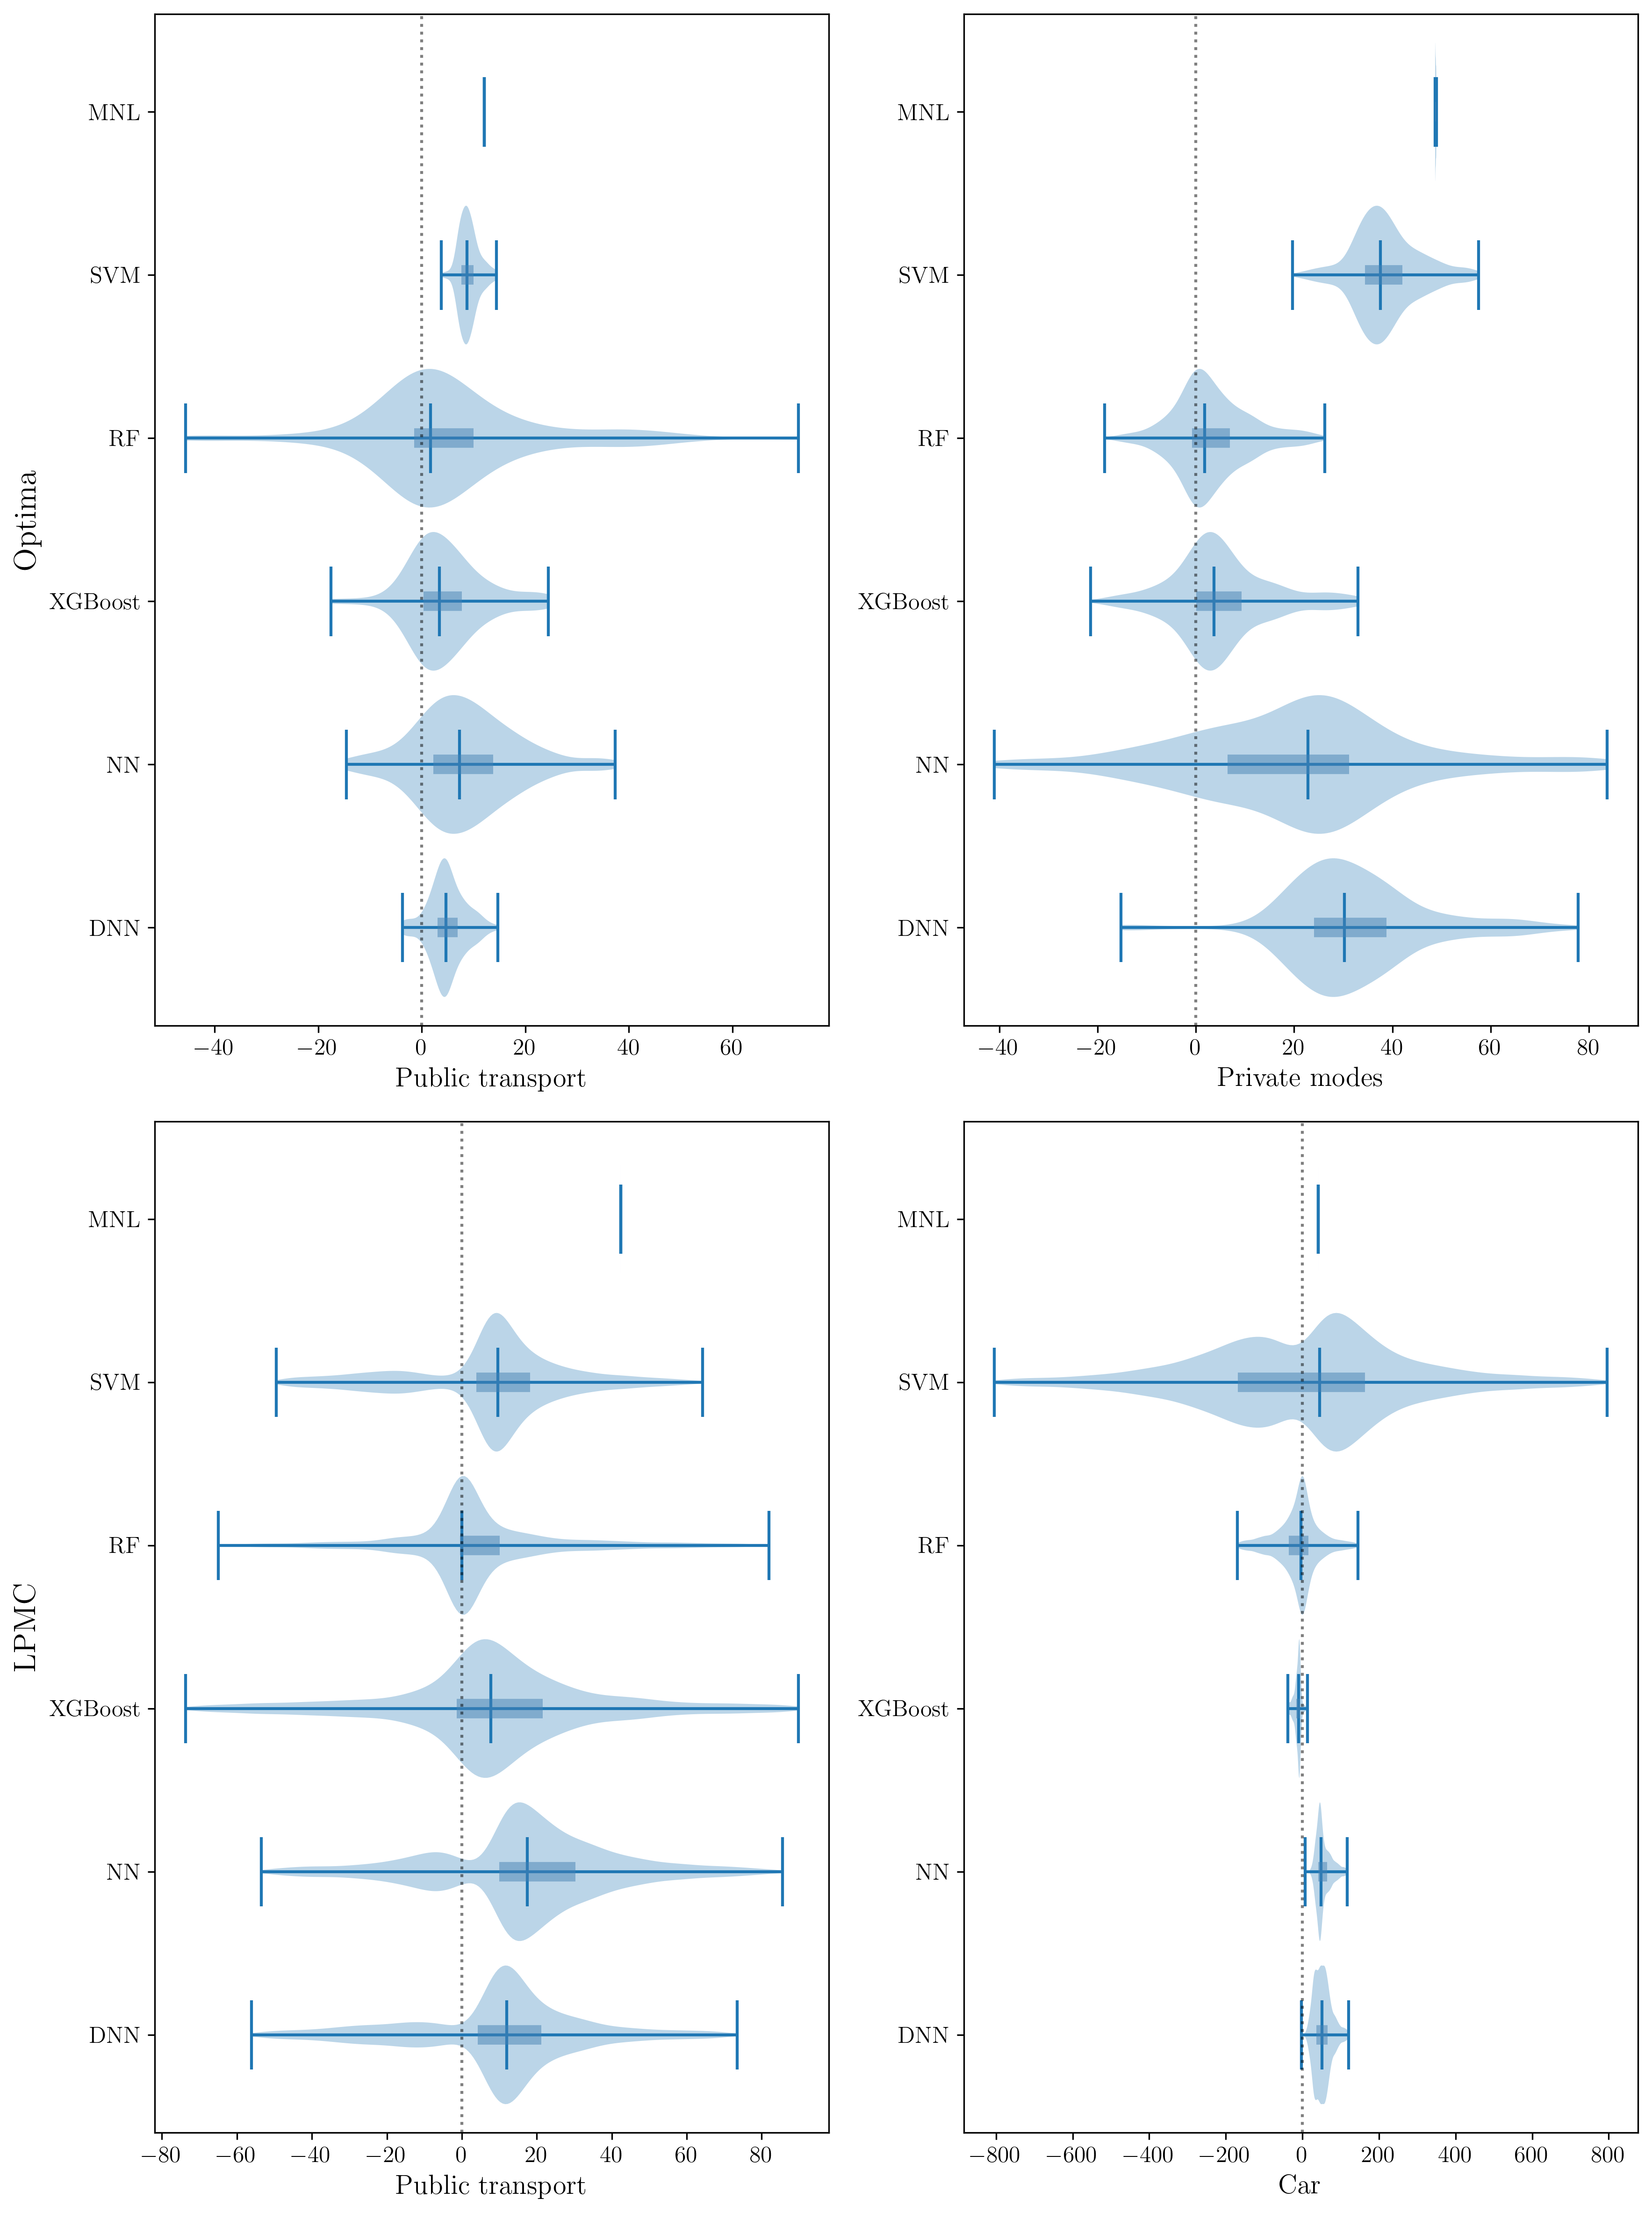

Non-valid observations (%)


,Optima,LPMC
MNL,0.271003,0.000000
SVM,0.000000,0.000000
RF,49.958203,40.572843
XGBoost,56.979122,42.917468
NN,0.907945,0.000000
DNN,0.271003,0.010526


In [26]:
## Export figures
non_valid_percent, median_WTP = Experiment_4_WTP(Experiment_4_test_scores, datasets, dir="Figures/")

# Print not valid willingness to pay values
print("Non-valid observations (%)")
display(non_valid_percent)

In [18]:
median_WTP

Optima                           LPMC           
        Public transport Private modes Public Transport        Car
MNL            12.118924     48.805813        42.391386  41.620671
SVM             8.741763     37.558550         9.597268  45.155618
RF              1.732209      1.750533         0.000000  -4.024618
XGBoost         3.385929      3.670491         7.768991 -10.329962
NN              7.265633     22.786282        17.457197  49.098102
DNN             4.635042     30.268901        11.992251  50.942638

In [20]:
pandas_to_latex(median_WTP, 'Latex_tables/experiment_4_WTP_table.tex', align_rest='l', index = True, multicolumn=True, fit_width=False, caption="Median of the estimated WTPs values by model for each real dataset on the test set", label="tab:experiment_4_WTP_table")

/mnt/Datos/Jose_Angel/Clasificadores/Codigos/JAT2022/expermients_functions.py:120: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_table.to_latex(escape=escape, index=index, column_format=cols, header=header, multicolumn=multicolumn, caption=caption, label=label,
